#### Import libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import random
import sys
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score

import tensorflow
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# from tf.keras.layers import Dense

In [2]:
#  Mount the drive to load datasets
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


#Data

## Synthetic data

In [3]:
# Creating synthetic data for testing the models
syntetic_dataset = {}
syntetic_dataset['num'] = [[-1.1], [0.2], [101.1], [0.3], [1], [0.5]]
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
rng = np.random.RandomState(42)
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
syntetic_dataset['norm'] = make_blobs(centers=[[0, 0], [0, 0]],
                                      cluster_std=0.5,
                                      **blobs_params)[0]
syntetic_dataset['2cluster'] = make_blobs(centers=[[2, 2], [-2, -2]],
                                          cluster_std=[0.5, 0.5],
                                          **blobs_params)[0]
syntetic_dataset['2moon'] = 4. * (make_moons(n_samples=n_samples,
                                             noise=.05,
                                             random_state=0)[0] 
                                  - np.array([0.5, 0.25]))

for dataset in syntetic_dataset.keys():
    # Add outliers
    if dataset == 'num':
      continue
    syntetic_dataset[dataset] = np.concatenate([syntetic_dataset[dataset],
                                                rng.uniform(low=-6, high=6, 
                                                size=(n_outliers, 2))],
                                                axis=0)

## MNIST

In [4]:
# Load MNIST dataset
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
#  Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data to run the NN models
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


#### Label Anamoly vs. Normal classes

In [6]:
# Treating [7,8,9] as the anamoly classes and all others as normal classes
anomalous_classes = [7,8,9]
mnist_anomaly = []
mnist_data=[]
for i, (image, label) in enumerate(zip(x_train, y_train)):
    if label in anomalous_classes:
        mnist_anomaly.append(image)
    else:
      mnist_data.append(image),
mnist_data = np.array(mnist_data)
mnist_anomaly = np.array(mnist_anomaly)

##Credit Card Fraud Detection

In [7]:
#  Load the credit card dataset
creditcard_df = pd.read_csv('/drive/My Drive/Data_colab/creditcard.csv')
print(creditcard_df.columns)
creditcard_df.fillna(0, inplace=True)
columns = [c for c in creditcard_df.columns if c not in ["Class"]]

# Store the variable we are predicting 
target = "Class"

# Define a random state 
state = np.random.RandomState(42)
creditcard_X = creditcard_df[columns]
creditcard_Y = creditcard_df[target]

# Print the shapes of X & Y
print(creditcard_X.shape)
print(creditcard_Y.shape)
np.unique(np.array(creditcard_Y), return_counts=True)

#  Scale the data to train the model
scaler = MinMaxScaler()
creditcard_X_scaled = scaler.fit_transform(creditcard_X)
creditcard_fraud = scaler.fit_transform(creditcard_df[creditcard_df['Class']==1][columns])
creditcard_normal = scaler.fit_transform(creditcard_df[creditcard_df['Class']==0][columns])

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
(284807, 30)
(284807,)


## Utility functions for building the model

In [8]:
def evaluation(lab, pred):
  c = Counter()
  c.update(pred.round())
  print('prediction frequency: ')
  print(c)
  print(f"Accuracy Score: {accuracy_score(lab, pred.round())}")
  print(f"F1 Score: {f1_score(lab, pred.round())}")
  print(f"Average Precision Score: {average_precision_score(lab, pred.round())}")
  print(f"AUROC Score: {roc_auc_score(lab, pred)}")
  print(f"Confusion Matrix:\n {confusion_matrix(lab, pred.round())}")
  print("Classification Report :")
  print(classification_report(lab,pred.round()))

In [9]:
def visualization(X,p,threshold=0.5):
    plt.figure(figsize=(10,10))

    plt.scatter(X[:,0],X[:,1],c=p,cmap='viridis',marker='x')
    outliers = np.nonzero(p<threshold)[0]
    plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
    plt.colorbar();

#Models

## Feedforward Neural Network

In [10]:
#  Defining the layers for the NN model

def NN_model(layer_widths=[784,10],activation='relu',final_activation='sigmoid'):
  input_layer = Input(shape=(layer_widths[0],))
  layer = input_layer
  for width in layer_widths[1:-1]:
      layer = Dense(
          units=width,
          activation=activation
      )(layer)
  output_layer = Dense(
          units=layer_widths[-1],
          activation=final_activation
      )(layer)
  nn = Model(input_layer, output_layer)
  nn.summary()
  return nn


## Auto Encoder NN

In [11]:
# Defining the architecture for the Autoencoder

def AE_model(layer_widths=[784,10],activation='relu',final_activation='sigmoid'):
  input_layer = Input(shape=(layer_widths[0],))
  layer = input_layer
  
  #Encoder
  for width in layer_widths[1:]:
      layer = Dense(
          units=width,
          activation=activation
      )(layer)
  
  #Decoder
  for width in layer_widths[-2:0:-1]:
      layer = Dense(
          units=width,
          activation=activation
      )(layer)
  output_layer = Dense(
          units=layer_widths[0],
          activation=final_activation
      )(layer)
  autoencoder = Model(input_layer, output_layer)
  autoencoder.summary()
  return autoencoder


##Testing AutoEncoders for anomaly detection

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
60/60 [==============================] - 13s 1ms/step - loss: 0.8249
Epoch 2/30
60/60 [==============================] - 0s 1ms/step - loss: 0.7689
Epoch 3/30
60/60 [==============================] - 0s 1ms/step - loss: 0.7699
Epoch 4/30
60/60 [==============================] - 0s 1ms/step - loss: 0.6418
Epoch 5/30
60/60 [==============================] - 0s 1ms/step - loss: 0.9321
E

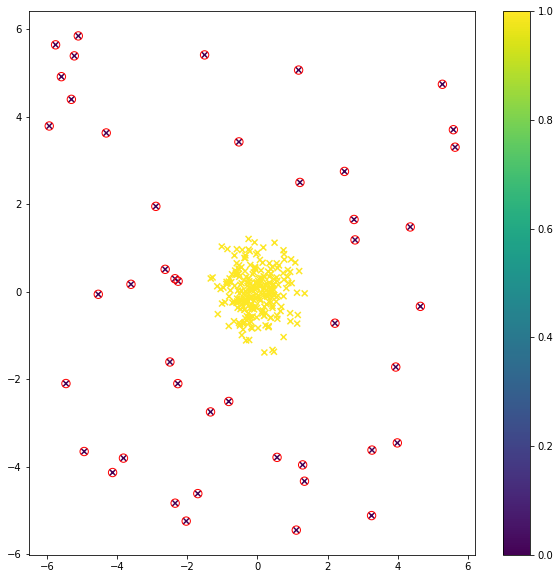

In [12]:
synt_data = syntetic_dataset['norm']
ae_synt = AE_model([2,1])
ae_synt.compile(optimizer='adam', loss='binary_crossentropy')
ae_synt.fit(synt_data, synt_data,
                epochs=30,
                batch_size=5,
                shuffle=True)

# Check the diff in value btw the original data and the generated data from Autoencoder --> reconstruction error
pred_synt = np.mean(np.square(synt_data-ae_synt.predict(synt_data)),axis=1)
visualization(synt_data,pred_synt<pred_synt.mean())

### Autoencoder on the MNIST dataset

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               24304     
Total params: 48,494
Trainable params: 48,494
Non-trainable params: 0
_________________________________________________________________


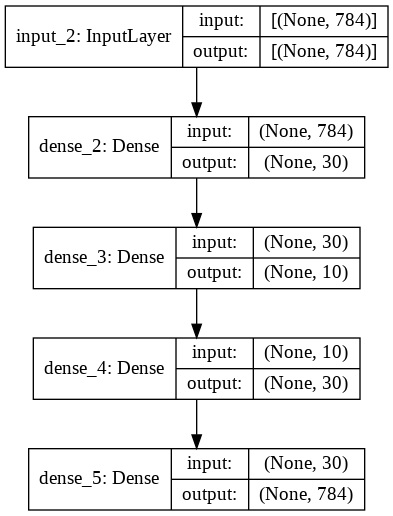

In [13]:
autoencoder = AE_model([784,30,10])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
plot_model(autoencoder,show_shapes=True)

In [14]:
# Autoencoder is modeled on the Normal/non anamoly data
autoencoder.fit(mnist_data, mnist_data,
                epochs=30,
                batch_size=256,
                shuffle=True)

Epoch 1/30
164/164 [==============================] - 3s 11ms/step - loss: 0.4222
Epoch 2/30
164/164 [==============================] - 2s 11ms/step - loss: 0.2096
Epoch 3/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1865
Epoch 4/30
164/164 [==============================] - 2s 10ms/step - loss: 0.1727
Epoch 5/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1660
Epoch 6/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1621
Epoch 7/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1588
Epoch 8/30
164/164 [==============================] - 2s 10ms/step - loss: 0.1561
Epoch 9/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1532
Epoch 10/30
164/164 [==============================] - 2s 10ms/step - loss: 0.1517
Epoch 11/30
164/164 [==============================] - 2s 11ms/step - loss: 0.1505
Epoch 12/30
164/164 [==============================] - 2s 10ms/step - loss: 0.1491
Epoch 13/30
1

In [15]:
# Trained AE is tested on the test set (with both anamoly and normal data points)
decoded_imgs = autoencoder.predict(x_test)

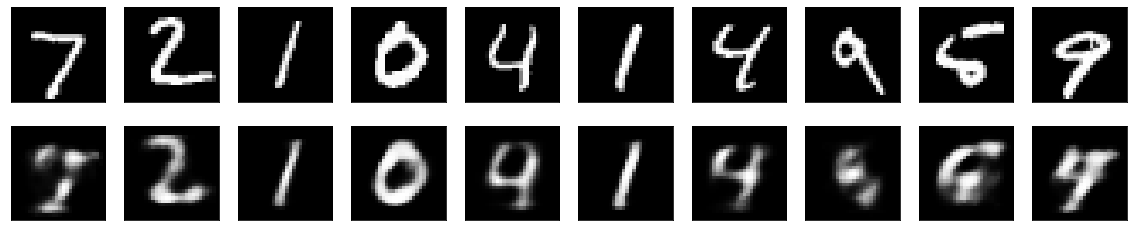

In [16]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
threashold = np.max(np.mean(np.square(x_test-autoencoder.predict(x_test)),axis=0))
print("threashold:%f" % threashold)

threashold:0.117244


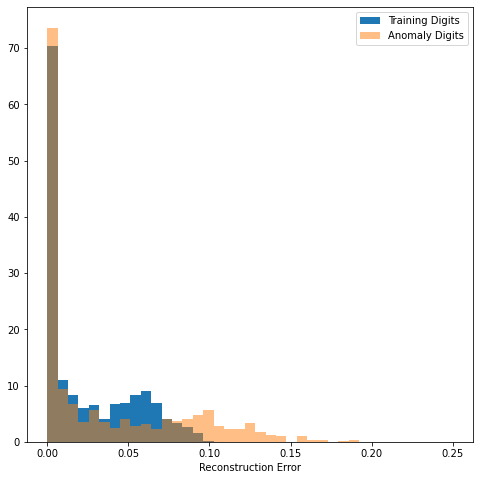

In [18]:
# Reconstruction error is calculated and it is observed that the reconstruction error is more for the anamoly digits
model_mse = lambda x: np.mean(np.square(x-autoencoder.predict(x)),axis=0)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(mnist_data), bins = np.linspace(0, 0.25, 40), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(mnist_anomaly), bins = np.linspace(0, 0.25, 40), label = 'Anomaly Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

##Credit card dataset

## **Exercise** Train the AE model for CCF dataset
Please report you best f1 score result on slack! :-)

Test different number of layers, layer size, number of batchs and number of epochs to see their effect!

call you model *autoencoder_ccf*

Once the model is trained run the next 2 cell to see its performance!


In [19]:
#Exercise - Write the code required for using AE yo detect anamolies in the Credit card fraud data

In [20]:
autoencoder_ccf = AE_model([30,20,5])
autoencoder_ccf.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_ccf.fit(creditcard_normal, creditcard_normal,
                epochs=30,
                batch_size=256)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                120       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                630       
Total params: 1,475
Trainable params: 1,475
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1111/1111 [==============================] - 3s 2ms/step - loss: 0.6073
Epoch 2/30
1111/1111 [==================

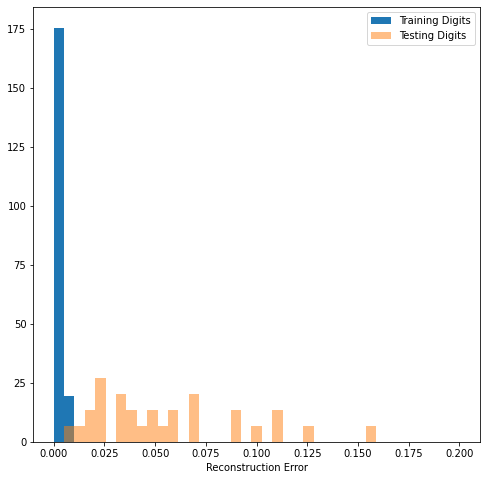

In [24]:
# Reconstruction error is calculated and it is observed that the reconstruction error is more for the fraud/anamoly transactions
model_mse = lambda x: np.mean(np.square(x-autoencoder_ccf.predict(x)),axis=0)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(creditcard_normal), bins = np.linspace(0, 0.2, 40), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(creditcard_fraud), bins = np.linspace(0, 0.2, 40), label = 'Testing Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [25]:
# Using the reconstruction error and a threshold anamoly points can be identified
pred_ccf = np.mean(np.square(creditcard_X_scaled-autoencoder_ccf.predict(creditcard_X_scaled)),axis=1)
Threshold = pred_ccf.mean() # what is the best threshold ?! 0.015?
evaluation(creditcard_Y, pred_ccf>Threshold)

prediction frequency: 
Counter({0.0: 171254, 1.0: 113553})
Accuracy Score: 0.6025483924201301
F1 Score: 0.0074356613617431715
Average Precision Score: 0.0034566244943774003
AUROC Score: 0.7319442007884018
Confusion Matrix:
 [[171186 113129]
 [    68    424]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.60      0.75    284315
           1       0.00      0.86      0.01       492

    accuracy                           0.60    284807
   macro avg       0.50      0.73      0.38    284807
weighted avg       1.00      0.60      0.75    284807



#Variational Autoencoder (VAE)

In [61]:
# Import the below to use the custom loss function
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
import horovod.tensorflow.keras as hvd
### end of hack

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim)) # , mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE_model(layer_widths=[784,10],activation='relu',final_activation='sigmoid', loss_func='mse'):
  original_dim = layer_widths[0]
  latent_dim = layer_widths[-1]
  #Encoder
  input_layer = Input(shape=(original_dim,))
  layer = input_layer
  for width in layer_widths[1:-1]:
      layer = Dense(
          units=width,
          activation=activation
      )(layer)

  z_mean = Dense(latent_dim, name='z_mean')(layer)
  z_log_var = Dense(latent_dim, name='z_log_var')(layer)

  z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  #Decoder
  layer = z
  for width in layer_widths[-2:0:-1]:
      layer = Dense(
          units=width,
          activation=activation
      )(layer)
  output_layer = Dense(
            units=original_dim,
            activation=final_activation
        )(layer)

  # instantiate VAE model
  vae = Model(input_layer, output_layer)

  def my_vae_loss(y_true, y_pred):
    if loss_func == 'mse':
      reconstruction_loss = mse(input_layer, output_layer)
    else:
      reconstruction_loss = binary_crossentropy(input_layer, output_layer)
    reconstruction_loss *= original_dim
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

  vae.compile(optimizer='adam',loss=my_vae_loss, experimental_run_tf_function=False)
  vae.summary()
  return vae

## Testing VAE

In [62]:
vae = VAE_model([784,30,10])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 30)           23550       input_7[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           310         dense_34[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           310         dense_34[0][0]                   
___________________________________________________________________________________________

In [63]:
vae.fit(mnist_data, mnist_data,
                epochs=25,
                batch_size=256,
                shuffle=True)

In [ ]:
vae_decoded_imgs = vae.predict(x_test)

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(vae_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


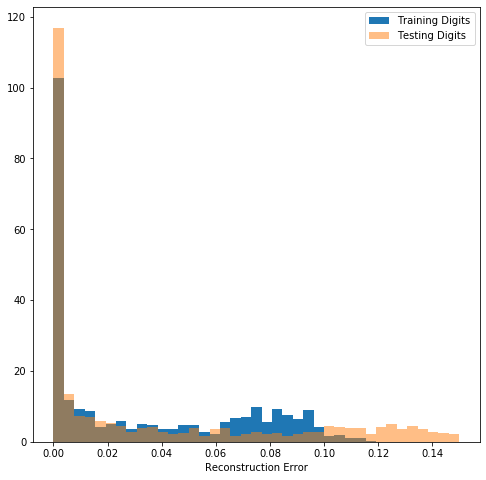

In [ ]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x)),axis=0)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(mnist_data), bins = np.linspace(0, 0.15, 40), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(mnist_anomaly), bins = np.linspace(0, 0.15, 40), label = 'Anomaly Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', normed = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

##Credit card dataset

## **Exercise** Train the VAE model for CCF dataset
Please report you best f1 score result on slack! :-)

Test different number of layers, layer size, number of batchs and number of epochs to see their effect!

call you model *vae_ccf*

Once the model is trained run the next 2 cell to see its performance!


In [ ]:
#Exercise

In [ ]:
vae_ccf = VAE_model([30,20,5])
vae_ccf.compile(optimizer='adam', loss='binary_crossentropy')
vae_ccf.fit(creditcard_normal, creditcard_normal,
                epochs=30,
                batch_size=256)

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 20)           620         input_46[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            105         dense_105[0][0]                  
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 5)            105         dense_105[0][0]                  
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


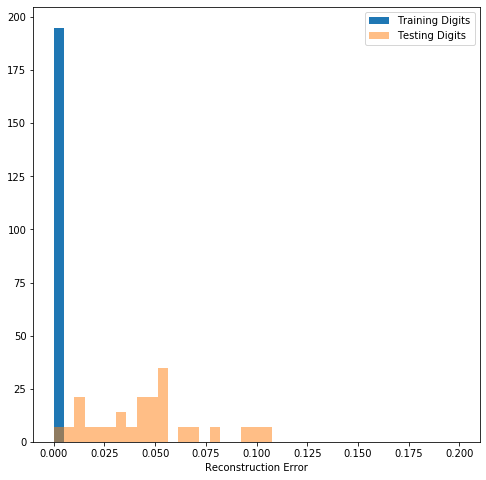

In [ ]:
model_mse = lambda x: np.mean(np.square(x-vae_ccf.predict(x)),axis=0)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(creditcard_normal), bins = np.linspace(0, 0.2, 40), label = 'Normal cases', normed = True, alpha = 1.0)
ax1.hist(model_mse(creditcard_fraud), bins = np.linspace(0, 0.2, 40), label = 'Anomaly cases', normed = True, alpha = 0.5)
# ax1.hist(model_mse(), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', normed = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [ ]:
pred_ccf = np.mean(np.square(creditcard_X_scaled-vae_ccf.predict(creditcard_X_scaled)),axis=1)
evaluation(creditcard_Y,pred_ccf>0.015)

prediction frequency: 
Counter({0.0: 284603, 1.0: 204})
Accuracy Score: 0.9983708265597404
F1 Score: 0.3333333333333333
Average Precision Score: 0.13538682705455005
AUROC Score: 0.6177314209348415
Confusion Matrix:
 [[284227     88]
 [   376    116]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.57      0.24      0.33       492

    accuracy                           1.00    284807
   macro avg       0.78      0.62      0.67    284807
weighted avg       1.00      1.00      1.00    284807



#Generative Adversarial Network (GAN)

In [64]:
def gan_model(layer_widths=[784,30,10],r_alpha=0.5):
  generator = AE_model(layer_widths=layer_widths,activation='relu',final_activation='sigmoid')

  discriminator = NN_model(layer_widths=layer_widths+[1],activation='relu',final_activation='sigmoid')
  discriminator.compile(optimizer='adam', loss='binary_crossentropy')

  img = Input(shape=(input_dim,))
  reconstructed_img = generator(img)
  discriminator.trainable = False
  validity = discriminator(reconstructed_img)

  # Model to train Generator/R to minimize reconstruction loss and trick D to see generated images as real ones.
  adversarial_model = Model(img, [reconstructed_img, validity])
  adversarial_model.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
      loss_weights=[r_alpha, 1],
      optimizer='adam')
  adversarial_model.summary()
  plot_model(adversarial_model,show_shapes=True,expand_nested=True)
  return [generator,discriminator,adversarial_model]

##Training GAN

In [65]:
def train_gan(generator,discriminator,adversarial_model,data = mnist_data,epochs = 10,batch_size = 128 ):
  counter = 1
  # Record generator/R network reconstruction training losses.
  plot_epochs = []
  plot_g_recon_losses = []
  ones = np.ones((batch_size, 1))
  zeros = np.zeros((batch_size, 1))
  # training
  for epoch in range(epochs):
    print('Epoch ({}/{})-------------------------------------------------'.format(epoch,epochs))
    batch_idxs = len(data) // batch_size
    for idx in range(0, batch_idxs):
      batch = data[idx * batch_size:(idx + 1) * batch_size]
      batch_images = np.array(batch).astype(np.float32)
      batch_fake_images = generator.predict(batch_images)
      # Update D network, minimize real images inputs->D-> ones, noisy z->R->D->zeros loss.
      d_loss_real = discriminator.train_on_batch(batch_images, ones)
      d_loss_fake = discriminator.train_on_batch(batch_fake_images, zeros)

      # Update R network twice, minimize noisy z->R->D->ones and reconstruction loss.
      adversarial_model.train_on_batch(batch_images, [batch_images, ones])
      g_loss = adversarial_model.train_on_batch(batch_images, [batch_images, ones])    
      plot_epochs.append(epoch+idx/batch_idxs)
      plot_g_recon_losses.append(g_loss[1])
      counter += 1
      msg = 'Epoch:[{0}]-[{1}/{2}] --> d_loss: {3:>0.3f}, g_loss:{4:>0.3f}, g_recon_loss:{4:>0.3f}'.format(epoch, idx, batch_idxs, d_loss_real+d_loss_fake, g_loss[0], g_loss[1])
      if idx%50==0:
        print(msg)

  plt.title('Generator/R network reconstruction losses')
  plt.xlabel('Epoch')
  plt.ylabel('training loss')
  plt.grid()
  plt.plot(plot_epochs,plot_g_recon_losses)
  # plt.savefig('plot_g_recon_losses.png')

##Testing GAN

In [67]:
# data = x_train
data = mnist_data
input_dim = 784
layer_widths =[784,40,10]
generator,discriminator,adversarial_model=gan_model(layer_widths=layer_widths,r_alpha=0.8)
train_gan(generator,discriminator,adversarial_model,data = data,epochs = 10,batch_size = 128 )

In [ ]:
def test_reconstruction(label, data_index = 11):
    specific_idx = np.where(y_train == label)[0]
    if data_index >= len(x_train):
        data_index = 0
    data = x_train[specific_idx][data_index:data_index+1]
    model_predicts = adversarial_model.predict(data)
    
    fig= plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((28, 28))
    reconstructed_image = model_predicts[0].reshape((28, 28))
    plt.title('Input')
    plt.imshow(input_image, label='Input')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    y_true = K.variable(reconstructed_image)
    y_pred = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print('Reconstruction loss:', error)
    print('Discriminator Output:', model_predicts[1][0][0])

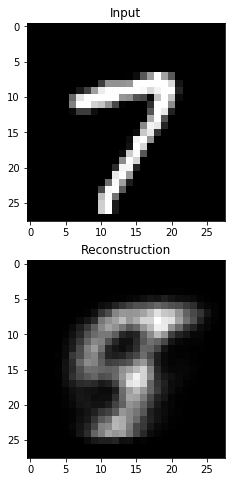

Reconstruction loss: 0.8858302
Discriminator Output: 0.50147927


In [ ]:
test_reconstruction(7)

##Credit card dataset

###**Exercise**: Implement GAN Anomaly detection model for CCF
Write the evaluation function and test your model

Please report you best f1 score result on slack! :-)

Test different number of layers, layer size,alpha, number of batchs and number of epochs to see their effect!


In [ ]:
data = creditcard_X_scaled
input_dim = 30
layer_widths =[30,20,10]
generator,discriminator,adversarial_model=gan_model(layer_widths=layer_widths,r_alpha=0.5)
train_gan(generator,discriminator,adversarial_model,data = data, epochs = 10,batch_size = 256 )

Some links for your development:

https://github.com/matken11235/keras-anogan

https://github.com/bumuckl/AutoencodersForUnsupervisedAnomalyDetection
